In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import numpy as np
from sklearn import svm
import xgboost as xg
from numpy import mean
from sklearn import metrics
from sklearn.model_selection import *
from scipy.stats import uniform, randint

In [36]:
ev_train = pd.read_csv('event_data_train.csv') # all steps data
sub_train = pd.read_csv('submissions_data_train.csv') # exercising steps data
ev_test = pd.read_csv('events_data_test.csv')
sub_test = pd.read_csv('submission_data_test.csv')

In [37]:
# create trget variable
ev_train['result'] = ev_train[ev_train.action == 'passed'].groupby('user_id').step_id.transform('nunique')
ev_train['result'] = np.where((ev_train['result'] >= 80), 1, 0)
ev_train['result'] = ev_train.groupby('user_id').result.transform('max')

result
0    1123099
1    2357604
Name: user_id, dtype: int64


0.4763730465336842

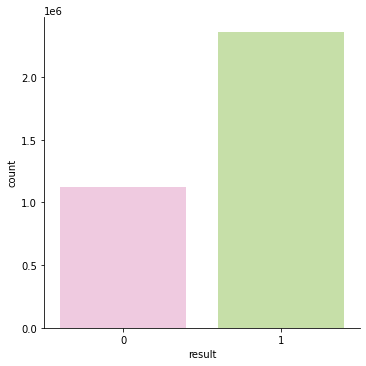

In [38]:
# Check the class balance for result variable
print(ev_train.groupby('result').user_id.count())
sns.catplot(x = 'result', kind = 'count', palette = 'PiYG', data = ev_train);
# We may see that classes are imbalanced
imb = ev_train.groupby('result').user_id.count()[0] / ev_train.groupby('result').user_id.count()[1]
imb

In [39]:
[df.dtypes for df in (ev_train, ev_test, sub_train, sub_test)]

[step_id       int64
 timestamp     int64
 action       object
 user_id       int64
 result        int32
 dtype: object,
 step_id       int64
 timestamp     int64
 action       object
 user_id       int64
 dtype: object,
 step_id               int64
 timestamp             int64
 submission_status    object
 user_id               int64
 dtype: object,
 step_id               int64
 timestamp             int64
 submission_status    object
 user_id               int64
 dtype: object]

In [40]:
[df.isnull().values.any() for df in (ev_train, ev_test, sub_train, sub_test)] # there are no missing values

[False, False, False, False]

In [41]:
ev_train['date'] = [d.date() for d in pd.to_datetime(ev_train['timestamp'], unit = 's')]
ev_test['date'] = [d.date() for d in pd.to_datetime(ev_test['timestamp'], unit = 's')]
sub_train['date'] = [d.date() for d in pd.to_datetime(sub_train['timestamp'], unit = 's')]
sub_test['date'] = [d.date() for d in pd.to_datetime(sub_test['timestamp'], unit = 's')]

In [42]:
ev_train['first_d'] = ev_train.groupby('user_id').date.transform('min')
m = ev_train.date <= pd.DatetimeIndex(ev_train.first_d) + DateOffset(days = 2)
ev_train = ev_train.loc[m]
#############################
sub_train['first_d'] = sub_train['user_id'].map(ev_train['first_d'])
m1 = sub_train.date <= pd.DatetimeIndex(sub_train.first_d) + DateOffset(days = 2)
sub_train = sub_train.loc[m1]
##################################
ev_test['first_d'] = ev_test.groupby('user_id').date.transform('min')
#############################
sub_test['first_d'] = sub_test['user_id'].map(ev_test['first_d']).copy()

In [43]:
# step_unique, step_passed, activity at the start of learning (0 day), activity on the first day, activity 
# on the second day
ev_train['step_unique'] = ev_train.groupby('user_id').step_id.transform('nunique')
ev_train['step_passed'] = ev_train[ev_train.action == 'passed'].groupby('user_id').step_id.transform('nunique')
ev_train['step_passed_0d'] = ev_train[(ev_train.action == 'passed') & (ev_train.date == ev_train.first_d)].groupby('user_id').step_id.transform('nunique')
ev_train['step_passed_1std'] = ev_train[(ev_train.action == 'passed') & (pd.DatetimeIndex(ev_train.date) - pd.DatetimeIndex(ev_train.first_d) == '1 days')].groupby('user_id').step_id.transform('nunique')
ev_train['step_passed_2nd'] = ev_train[(ev_train.action == 'passed') & (pd.DatetimeIndex(ev_train.date) - pd.DatetimeIndex(ev_train.first_d) == '2 days')].groupby('user_id').step_id.transform('nunique')

# result (it was said that the threshold is 40)
#ev_train['result'] = 0
#ev_train.loc[ev_train['step_passed'] >= 40, 'result'] = 1
# replace Nan with 0 steps:
ev_train = ev_train.fillna(0)

In [44]:
# the same for ev_test
ev_test['step_unique'] = ev_test.groupby('user_id').step_id.transform('nunique')
ev_test['step_passed'] = ev_test[ev_test.action == 'passed'].groupby('user_id').step_id.transform('nunique')
ev_test['step_passed_0d'] = ev_test[(ev_test.action == 'passed') & (ev_test.date == ev_test.first_d)].groupby('user_id').step_id.transform('nunique')
ev_test['step_passed_1std'] = ev_test[(ev_test.action == 'passed') & (pd.DatetimeIndex(ev_test.date) - pd.DatetimeIndex(ev_test.first_d) == '1 days')].groupby('user_id').step_id.transform('nunique')
ev_test['step_passed_2nd'] = ev_test[(ev_test.action == 'passed') & (pd.DatetimeIndex(ev_test.date) - pd.DatetimeIndex(ev_test.first_d) == '2 days')].groupby('user_id').step_id.transform('nunique')

# result (it was said that the threshold is 40)
ev_test['result'] = 0
ev_test.loc[ev_test['step_passed'] >= 40, 'result'] = 1
# replace Nan with 0 steps:
ev_test = ev_test.fillna(0)

In [45]:
# task unique, tasks_correct, 0 day tasks_correct, 1st day tasks_correct, 2 nd day tasks_correct
sub_train['tasks_unique'] = sub_train.groupby('user_id').step_id.transform('nunique')
sub_train['tasks_correct'] = sub_train[sub_train.submission_status == 'correct'].groupby('user_id').step_id.transform('nunique')
sub_train['tasks_correct_0st'] = sub_train[(sub_train.submission_status == 'correct') & (sub_train.date == sub_train.first_d)].groupby('user_id').step_id.transform('nunique')
sub_train['tasks_correct_1st'] = sub_train[(sub_train.submission_status == 'correct') & (pd.DatetimeIndex(sub_train.date) - pd.DatetimeIndex(sub_train.first_d) == '1 days')].groupby('user_id').step_id.transform('nunique')
sub_train['tasks_correct_2nd'] = sub_train[(sub_train.submission_status == 'correct') & (pd.DatetimeIndex(sub_train.date) - pd.DatetimeIndex(sub_train.first_d) == '2 days')].groupby('user_id').step_id.transform('nunique')

# find the number of solving task attempts 
sub_train['tasks_attempts'] = sub_train.groupby(['user_id', 'step_id']).submission_status.transform('count')
# replace Nan with 0:
sub_train = sub_train.fillna(0)

In [46]:
# the same for esub_test
sub_test['tasks_unique'] = sub_test.groupby('user_id').step_id.transform('nunique')
sub_test['tasks_correct'] = sub_test[sub_test.submission_status == 'correct'].groupby('user_id').step_id.transform('nunique')
sub_test['tasks_correct_0st'] = sub_test[(sub_test.submission_status == 'correct') & (sub_test.date == sub_test.first_d)].groupby('user_id').step_id.transform('nunique')
sub_test['tasks_correct_1st'] = sub_test[(sub_test.submission_status == 'correct') & (pd.DatetimeIndex(sub_test.date) - pd.DatetimeIndex(sub_test.first_d) == '1 days')].groupby('user_id').step_id.transform('nunique')
sub_test['tasks_correct_2nd'] = sub_test[(sub_test.submission_status == 'correct') & (pd.DatetimeIndex(sub_test.date) - pd.DatetimeIndex(sub_test.first_d) == '2 days')].groupby('user_id').step_id.transform('nunique')

# find the number of solving task attempts 
sub_test['tasks_attempts'] = sub_test.groupby(['user_id', 'step_id']).submission_status.transform('count')
# replace Nan with 0:
sub_test = sub_test.fillna(0)

In [47]:
print(len(ev_train.user_id.unique()))
print(len(sub_train.user_id.unique()))
print(len(ev_test.user_id.unique()))
print(len(sub_test.user_id.unique()))

19234
871
6184
2803


In [48]:
# find the most difficult tasks
diff = sub_train.drop_duplicates(subset = ['user_id', 'step_id'], keep = 'last').groupby('step_id').tasks_attempts.mean().sort_values()
# let's suppose that if average amount of attempts are 4 or more, the task is difficult. 
diff = diff[diff > 3].index
diff

Int64Index([32075, 31981, 32202, 32795, 32810, 33350, 32206, 32796], dtype='int64', name='step_id')

In [49]:
# Create dummy variables for solving the most difficalt tasks
dummy = []
for i in diff: 
    dummy.append('is_' + str(i))
    sub_train['is_' + str(i)] = np.where((sub_train['step_id'] == i) & (sub_train['submission_status'] == 'correct'), 1, 0)
for i in diff: 
    sub_test['is_' + str(i)] = np.where((sub_test['step_id'] == i) & (sub_test['submission_status'] == 'correct'), 1, 0)
    
for i in dummy: 
    sub_train.loc[:, i] = sub_train.groupby('user_id')[i].transform('max')
    sub_test.loc[:, i] = sub_test.groupby('user_id')[i].transform('max')

In [50]:
sub_train['tasks_attempts_total'] = sub_train.groupby(['user_id']).step_id.transform('count')
sub_test['tasks_attempts_total'] = sub_test.groupby(['user_id']).step_id.transform('count')

In [51]:
print(sub_train.shape)
print(sub_test.shape)

(10999, 21)
(42261, 21)


In [52]:
#pd.set_option('display.max_columns', None)
sub_train[['tasks_correct', 'tasks_correct_0st', 'tasks_correct_1st', 'tasks_correct_2nd']] = sub_train.groupby('user_id')[['tasks_correct', 'tasks_correct_0st', 'tasks_correct_1st', 'tasks_correct_2nd']].transform('max')
sub_test[['tasks_correct', 'tasks_correct_0st', 'tasks_correct_1st', 'tasks_correct_2nd']] = sub_test.groupby('user_id')[['tasks_correct', 'tasks_correct_0st', 'tasks_correct_1st', 'tasks_correct_2nd']].transform('max')
ev_train[['step_passed', 'step_passed_0d', 'step_passed_1std', 'step_passed_2nd']] = ev_train.groupby('user_id')[['step_passed', 'step_passed_0d', 'step_passed_1std', 'step_passed_2nd']].transform('max')
ev_test[['step_passed', 'step_passed_0d', 'step_passed_1std', 'step_passed_2nd']] = ev_test.groupby('user_id')[['step_passed', 'step_passed_0d', 'step_passed_1std', 'step_passed_2nd']].transform('max')

In [53]:
train_1 =  ev_train[['user_id', 'step_unique', 'step_passed_0d', 'step_passed_1std', 'step_passed_2nd', 'result']].drop_duplicates(subset = ['user_id'], keep = 'last')
test_1 = ev_test[['user_id', 'step_unique', 'step_passed_0d', 'step_passed_1std', 'step_passed_2nd', 'result']].drop_duplicates(subset = ['user_id'], keep = 'last')
train_2 =  sub_train[['user_id', 'tasks_unique', 'tasks_correct_1st', 'tasks_correct_2nd', 'tasks_attempts', 'is_32075', 'is_31981', 'is_32202', 'is_32795', 'is_32810', 'is_33350', 'is_32206', 'is_32796']].drop_duplicates(subset = ['user_id'], keep = 'last')
test_2 = sub_test[['user_id', 'tasks_unique', 'tasks_correct_1st', 'tasks_correct_2nd', 'tasks_attempts', 'is_32075', 'is_31981', 'is_32202', 'is_32795', 'is_32810', 'is_33350', 'is_32206', 'is_32796']].drop_duplicates(subset = ['user_id'], keep = 'last')
train = pd.merge(train_1, train_2, how = 'left')
train = train.fillna(0)
test = pd.merge(test_1, test_2, how = 'left')
test = test.fillna(0)

In [54]:
y_train = train.result
X_train = train.drop('result', 1)
y_test = test.result
X_test = test.drop('result', 1)

In [55]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

(6184, 17)
(19234, 17)
(6184,)
(19234,)


In [105]:
clf_xg = xg.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc', use_label_encoder = False)
params = {'n_estimators': randint(100, 500),
              'eta': uniform(0.01, 0.6),
              'subsample': uniform(0.3, 0.9),
              'max_depth': randint(2, 10),
              'colsample_bytree': uniform(0.5, 0.9),
              'min_child_weight': randint(1,5),
              'scale_pos_weight': [imb, 1],
              'gamma': uniform(0, 0.9)
             }

kfold = KFold(n_splits=10, shuffle=True)

clf = RandomizedSearchCV(clf_xg, 
                         param_distributions = params,
                         cv = kfold,  
                         n_iter = 50,
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1,
                        refit=True)

In [106]:
clf.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='auc', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=No...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000232B63667C8>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00

In [107]:
y_pred = clf.predict(X_test)
cm = metrics.confusion_matrix(y_test,y_pred) 
print(cm)
auc_xg = np.round(metrics.roc_auc_score(y_test, y_pred),2)
print('auc: ', auc_xg)

[[5391  398]
 [   6  389]]
auc:  0.96


In [108]:
###
ev_test1 = pd.read_csv('events_data_test_1.csv')
sub_test1 = pd.read_csv('submission_data_test_1.csv')
ev_test1['date'] = [d.date() for d in pd.to_datetime(ev_test1['timestamp'], unit = 's')]
sub_test1['date'] = [d.date() for d in pd.to_datetime(sub_test1['timestamp'], unit = 's')]
ev_test1['first_d'] = ev_test1.groupby('user_id').date.transform('min')
sub_test1['first_d'] = sub_test1['user_id'].map(ev_test1['first_d']).copy()
ev_test1['step_unique'] = ev_test1.groupby('user_id').step_id.transform('nunique')
ev_test1['step_passed'] = ev_test1[ev_test1.action == 'passed'].groupby('user_id').step_id.transform('nunique')
ev_test1['step_passed_0d'] = ev_test1[(ev_test1.action == 'passed') & (ev_test1.date == ev_test1.first_d)].groupby('user_id').step_id.transform('nunique')
ev_test1['step_passed_1std'] = ev_test1[(ev_test1.action == 'passed') & (pd.DatetimeIndex(ev_test1.date) - pd.DatetimeIndex(ev_test1.first_d) == '1 days')].groupby('user_id').step_id.transform('nunique')
ev_test1['step_passed_2nd'] = ev_test1[(ev_test1.action == 'passed') & (pd.DatetimeIndex(ev_test1.date) - pd.DatetimeIndex(ev_test1.first_d) == '2 days')].groupby('user_id').step_id.transform('nunique')

# result (it was said that the threshold is 40)
ev_test1['result'] = 0
ev_test1.loc[ev_test1['step_passed'] >= 40, 'result'] = 1
# replace Nan with 0 steps:
ev_test1 = ev_test1.fillna(0)
sub_test1['tasks_unique'] = sub_test1.groupby('user_id').step_id.transform('nunique')
sub_test1['tasks_correct'] = sub_test1[sub_test1.submission_status == 'correct'].groupby('user_id').step_id.transform('nunique')
sub_test1['tasks_correct_0st'] = sub_test1[(sub_test1.submission_status == 'correct') & (sub_test1.date == sub_test1.first_d)].groupby('user_id').step_id.transform('nunique')
sub_test1['tasks_correct_1st'] = sub_test1[(sub_test1.submission_status == 'correct') & (pd.DatetimeIndex(sub_test1.date) - pd.DatetimeIndex(sub_test1.first_d) == '1 days')].groupby('user_id').step_id.transform('nunique')
sub_test1['tasks_correct_2nd'] = sub_test1[(sub_test1.submission_status == 'correct') & (pd.DatetimeIndex(sub_test1.date) - pd.DatetimeIndex(sub_test1.first_d) == '2 days')].groupby('user_id').step_id.transform('nunique')

# find the number of solving task attempts 
sub_test1['tasks_attempts'] = sub_test1.groupby(['user_id', 'step_id']).submission_status.transform('count')
# replace Nan with 0:
sub_test1 = sub_test1.fillna(0)

for i in diff: 
    sub_test1['is_' + str(i)] = np.where((sub_test1['step_id'] == i) & (sub_test1['submission_status'] == 'correct'), 1, 0)
    
for i in dummy: 
    sub_test1.loc[:, i] = sub_test1.groupby('user_id')[i].transform('max')

sub_test1['tasks_attempts_total'] = sub_test1.groupby(['user_id']).step_id.transform('count')

sub_test1[['tasks_correct', 'tasks_correct_0st', 'tasks_correct_1st', 'tasks_correct_2nd']] = sub_test1.groupby('user_id')[['tasks_correct', 'tasks_correct_0st', 'tasks_correct_1st', 'tasks_correct_2nd']].transform('max')
ev_test1[['step_passed', 'step_passed_0d', 'step_passed_1std', 'step_passed_2nd']] = ev_test1.groupby('user_id')[['step_passed', 'step_passed_0d', 'step_passed_1std', 'step_passed_2nd']].transform('max')
test1_1 = ev_test1[['user_id', 'step_unique', 'step_passed_0d', 'step_passed_1std', 'step_passed_2nd', 'result']].drop_duplicates(subset = ['user_id'], keep = 'last')
test1_2 = sub_test1[['user_id', 'tasks_unique', 'tasks_correct_1st', 'tasks_correct_2nd', 'tasks_attempts', 'is_32075', 'is_31981', 'is_32202', 'is_32795', 'is_32810', 'is_33350', 'is_32206', 'is_32796']].drop_duplicates(subset = ['user_id'], keep = 'last')

test1 = pd.merge(test1_1, test1_2, how = 'left')
test1 = test1.fillna(0)

y_test1 = test1.result
X_test1 = test1.drop('result', 1)

In [109]:
pred_xg1 = clf.predict(X_test1)
prob_xg1 = clf.predict_proba(X_test1)

In [110]:
output1 = pd.concat([pd.DataFrame(X_test1.user_id), pd.DataFrame(pd.DataFrame(np.round(prob_xg1,2))[1])], axis = 1)
output1.columns = ['user_id','is_gone']
output = output1.set_index('user_id')
output1.to_csv('final.csv')